In [2]:
!pip install transformers==3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 754.6/754.6 kB 5.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 38.2 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.12.1
    Uninstalling tokenizers-0.12.1:
      Successfully uninstalled tokenizers-0.12.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.20.1
    Uninstalling transformers-4.20.1:
      Successfully uninstalled transformers-4.20.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 2.10.1 requires transformers<4.21,>=4.1, but you have transformers 3.0.0 which is incompatible.


In [5]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


2022-12-15 17:46:50.514793: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 17:46:50.515575: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 17:46:50.516282: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 17:46:50.517026: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 17:46:50.517702: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [6]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 2 GPU(s) available.
We will use the GPU: Tesla T4


In [7]:
# Importing stock ml libraries
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split

import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig

The current process just got forked. Disabling parallelism to avoid deadlocks...
To disable this warning, please explicitly set TOKENIZERS_PARALLELISM=(true | false)
The current process just got forked. Disabling parallelism to avoid deadlocks...
To disable this warning, please explicitly set TOKENIZERS_PARALLELISM=(true | false)


wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


The current process just got forked. Disabling parallelism to avoid deadlocks...
To disable this warning, please explicitly set TOKENIZERS_PARALLELISM=(true | false)


In [8]:
raw_data_path = "/kaggle/input/resumedataset/resume_dataset_entities.csv"
# destination_folder = '/content/'

df_raw =  pd.read_csv(raw_data_path)
# df_raw = df_raw.head(1000)
df_raw.head()

,Text,Roles_Skills,Education,Experience,Additional_Information,Software_Developer,Front_End_Developer,Network_Administrator,Web_Developer,Project_manager,Database_Administrator,Security_Analyst,Systems_Administrator,Python_Developer,Java_Developer
0,Help Desk Support Analyst Help Desk Support An...,"['Help Desk Support Analyst', 'IT Support Anal...",The Ohio State University 2011 to 2012,Help Desk Support Analyst PCM IT Solutions Se...,Skills Adaptability Calm reassuring influenc...,0,0,0,0,1,0,0,0,0,0
1,Python Developer Python Developer Python Devel...,"['Python Developer', 'Python Developer', 'Pyth...",Bachelors,Python Developer PIMCO - Newport Beach CA Octo...,TECHNICAL SKILLS Cloud Microsoft Azure Amazon ...,1,0,0,0,0,0,0,0,1,0
2,Software Developer Software Developer Software...,"['Software Developer', 'Software Test Analyst'...",Bachelor of Science in Electrical Engineering ...,Software Developer General Atomics Aeronautica...,Technical Skills Computer Object Oriented Pro...,1,0,0,0,0,0,0,0,0,0
3,Business Analyst Business Analyst Business Ana...,"['Business Analyst', 'Research Assistant', 'Re...",M.S.,Business Analyst Powerlinx - New York NY July ...,Leadership Capability Tai Chi Club Fudan Univ...,0,0,0,0,0,0,1,0,0,0
4,Freelance Web Developer Freelance Web Develope...,"['Freelance Web Developer', 'HTML5', 'SASS', '...",B.A.,Freelance Web Developer Self-Exmployed - Bould...,NaN,1,0,0,1,0,0,0,0,0,0


In [9]:
df_raw['Text'][0]

'Help Desk Support Analyst Help Desk Support Analyst Columbus OH Creative and driven individual looking to build and facilitate relationships between all people. Understands that the best leaders are those who realize when to lead and when to follow. Won the Courtney Hodapp Leadership Award through the i.c. stars program. Work Experience Help Desk Support Analyst PCM IT Solutions  Services - Columbus OH August 2018 to January 2019 Duties Participated in a hardware refresh for JP Morgan Chases teller computers. Providing software assistance for technicians on site at JPMC branches across the country. Responsible for maintaining bridge line with multiple techs assuring old stations were wiped and that new computers imaged and built correctly. Also trouble shooting arising issues whether it was hardware or software related. IT Support Analyst The Wendys Company February 2018 to August 2018 Duties Troubleshooting hardware and software at restaurants to ensure day to day business runs smoot

In [10]:
df_raw.shape

(29780, 15)

In [11]:
df_raw.columns

Index(['Text', 'Roles_Skills', 'Education', 'Experience',
       'Additional_Information', 'Software_Developer', 'Front_End_Developer',
       'Network_Administrator', 'Web_Developer', 'Project_manager',
       'Database_Administrator', 'Security_Analyst', 'Systems_Administrator',
       'Python_Developer', 'Java_Developer'],
      dtype='object')

In [12]:
df_raw['target_list'] = df_raw[['Software_Developer', 'Front_End_Developer',
       'Network_Administrator', 'Web_Developer', 'Project_manager',
       'Database_Administrator', 'Security_Analyst', 'Systems_Administrator',
       'Python_Developer', 'Java_Developer']].values.tolist()

In [37]:
# df = df_raw[['Software_Developer', 'Front_End_Developer',
#        'Network_Administrator', 'Web_Developer', 'Project_manager',
#        'Database_Administrator', 'Security_Analyst', 'Systems_Administrator',
#        'Python_Developer', 'Java_Developer']]
df['target_list'] = df_raw[['Software_Developer', 'Front_End_Developer',
       'Network_Administrator', 'Web_Developer', 'Project_manager',
       'Database_Administrator', 'Security_Analyst', 'Systems_Administrator',
       'Python_Developer', 'Java_Developer']].values.tolist()
# df['Skills+Experience'] = df_raw['Roles_Skills']+df_raw['Experience']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [38]:
# df['RolesSkills'] = [''.join(l) for l in df_raw['Roles_Skills']]
df['RolesSkills'] = df_raw['Roles_Skills'].apply(eval).apply(' '.join)
# df['RolesSkills'] = df_raw['Roles_Skills'].apply(lambda x: ''.join(x))
df['Skills+Experience'] = df['RolesSkills']+" "+df_raw['Experience']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [39]:
df['Skills+Experience'][0]

'Help Desk Support Analyst IT Support Analyst Project Manager/ Developer Meat Counter Specialist Help Desk Desktop Support Service Desk Tech Support Helpdesk Support VPN Active Directory Help Desk Support Analyst PCM IT Solutions  Services - Columbus OH August 2018 to January 2019 Duties Participated in a hardware refresh for JP Morgan Chases teller computers.'

In [40]:
df

,Software_Developer,Front_End_Developer,Network_Administrator,Web_Developer,Project_manager,Database_Administrator,Security_Analyst,Systems_Administrator,Python_Developer,Java_Developer,RolesSkills,Skills+Experience,target_list
0,0,0,0,0,1,0,0,0,0,0,Help Desk Support Analyst IT Support Analyst P...,Help Desk Support Analyst IT Support Analyst P...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
1,1,0,0,0,0,0,0,0,1,0,Python Developer Python Developer Python Devel...,Python Developer Python Developer Python Devel...,"[1, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
2,1,0,0,0,0,0,0,0,0,0,Software Developer Software Test Analyst Telec...,Software Developer Software Test Analyst Telec...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,0,0,0,0,0,0,1,0,0,0,Business Analyst Research Assistant Research A...,Business Analyst Research Assistant Research A...,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
4,1,0,0,1,0,0,0,0,0,0,Freelance Web Developer HTML5 SASS UI PROTOTYP...,Freelance Web Developer HTML5 SASS UI PROTOTYP...,"[1, 0, 0, 1, 0, 0, 0, 0, 0, 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29775,0,0,1,0,0,1,0,0,0,0,Managing Director Database Administrator Netwo...,Managing Director Database Administrator Netwo...,"[0, 0, 1, 0, 0, 1, 0, 0, 0, 0]"
29776,1,0,0,1,0,0,0,0,1,0,Web Developer Python Developer DJANGO (1 year)...,Web Developer Python Developer DJANGO (1 year)...,"[1, 0, 0, 1, 0, 0, 0, 0, 1, 0]"
29777,0,0,0,0,0,0,0,1,0,0,Systems Administrator Senior Systems Administr...,Systems Administrator Senior Systems Administr...,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
29778,0,0,0,0,0,1,0,0,0,0,Database Administrator Database Administrator ...,Database Administrator Database Administrator ...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"


In [ ]:
df['WORD_COUNT'] = df['Skills+Experience'].apply(lambda x: len(x.split()))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7fcefda0a0>]],
      dtype=object)

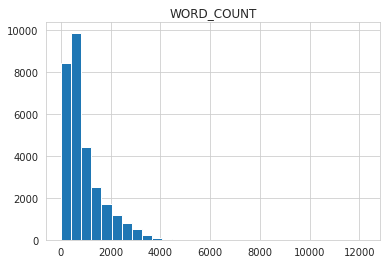

In [53]:
df_raw.hist('WORD_COUNT', bins=30)

In [41]:
df2 = df[['Skills+Experience', 'target_list']].copy()
df2.head()

,Skills+Experience,target_list
0,Help Desk Support Analyst IT Support Analyst P...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
1,Python Developer Python Developer Python Devel...,"[1, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
2,Software Developer Software Test Analyst Telec...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,Business Analyst Research Assistant Research A...,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
4,Freelance Web Developer HTML5 SASS UI PROTOTYP...,"[1, 0, 0, 1, 0, 0, 0, 0, 0, 0]"


In [44]:
# Sections of config

# Defining some key variables that will be used later on in the training
MAX_LEN = 256
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 4
LEARNING_RATE = 1e-05
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [47]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe['Skills+Experience']
        self.targets = self.data.target_list
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [48]:
train_size = 0.8
train_dataset = df2.sample(frac=train_size,random_state=200)
valid_dataset = df2.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)


print("FULL Dataset: {}".format(df2.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(valid_dataset.shape))

training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
validation_set = CustomDataset(valid_dataset, tokenizer, MAX_LEN)

FULL Dataset: (29780, 2)
TRAIN Dataset: (23824, 2)
TEST Dataset: (5956, 2)


In [50]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
validation_loader = DataLoader(validation_set, **test_params)

In [51]:
len(training_loader)

745

In [52]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 10)
    
    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

model = BERTClass()
model.to(device)

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    

In [53]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [54]:
len(training_loader)

745

In [55]:
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], valid_loss_min.item()

In [56]:
import shutil, sys   
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)

In [57]:
#to use as global variables
val_targets=[]
val_outputs=[] 

In [58]:
def train_model(start_epochs,  n_epochs, valid_loss_min_input, 
                training_loader, validation_loader, model, 
                optimizer, checkpoint_path, best_model_path):
   
  # initialize tracker for minimum validation loss
  valid_loss_min = valid_loss_min_input 
   
 
  for epoch in range(start_epochs, n_epochs+1):
    train_loss = 0
    valid_loss = 0

    model.train()
    print('############# Epoch {}: Training Start   #############'.format(epoch))
    for batch_idx, data in enumerate(training_loader):
        #print('yyy epoch', batch_idx)
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        #if batch_idx%5000==0:
         #   print(f'Epoch: {epoch}, Training Loss:  {loss.item()}')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print('before loss data in training', loss.item(), train_loss)
        train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))
        #print('after loss data in training', loss.item(), train_loss)
    
    print('############# Epoch {}: Training End     #############'.format(epoch))
    
    print('############# Epoch {}: Validation Start   #############'.format(epoch))
    ######################    
    # validate the model #
    ######################
 
    model.eval()
   
    with torch.no_grad():
      for batch_idx, data in enumerate(validation_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))
            val_targets.extend(targets.cpu().detach().numpy().tolist())
            val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

      print('############# Epoch {}: Validation End     #############'.format(epoch))
      # calculate average losses
      #print('before cal avg train loss', train_loss)
      train_loss = train_loss/len(training_loader)
      valid_loss = valid_loss/len(validation_loader)
      # print training/validation statistics 
      print('Epoch: {} \tAvgerage Training Loss: {:.6f} \tAverage Validation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
      
      # create checkpoint variable and add important data
      checkpoint = {
            'epoch': epoch + 1,
            'valid_loss_min': valid_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
      }
        
        # save checkpoint
      save_ckp(checkpoint, False, checkpoint_path, best_model_path)
        
      ## TODO: save the model if validation loss has decreased
      if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
        # save checkpoint as best model
        save_ckp(checkpoint, True, checkpoint_path, best_model_path)
        valid_loss_min = valid_loss

    print('############# Epoch {}  Done   #############\n'.format(epoch))


  return model

In [66]:
checkpoint_path = '/kaggle/working/current_checkpoint.pt'
best_model = '/kaggle/working/best_model.pt'
trained_model = train_model(1, 2, np.Inf, training_loader, validation_loader, model, 
                      optimizer,checkpoint_path,best_model)

############# Epoch 1: Training Start   #############
############# Epoch 1: Training End     #############
############# Epoch 1: Validation Start   #############
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 0.000087 	Average Validation Loss: 0.000258
Validation loss decreased (inf --> 0.000258).  Saving model ...
############# Epoch 1  Done   #############

############# Epoch 2: Training Start   #############
############# Epoch 2: Training End     #############
############# Epoch 2: Validation Start   #############
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.000048 	Average Validation Loss: 0.000160
Validation loss decreased (0.000258 --> 0.000160).  Saving model ...
############# Epoch 2  Done   #############



In [67]:
val_preds = (np.array(val_outputs) > 0.5).astype(int)
val_preds

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 1, 0, 0],
       [0, 0, 1, ..., 1, 0, 0]])

In [68]:
accuracy = metrics.accuracy_score(val_targets, val_preds)
f1_score_micro = metrics.f1_score(val_targets, val_preds, average='micro')
f1_score_macro = metrics.f1_score(val_targets, val_preds, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.9225430937989703
F1 Score (Micro) = 0.9750595312695827
F1 Score (Macro) = 0.9721621461838623


In [69]:
from sklearn.metrics import multilabel_confusion_matrix as mcm, classification_report

In [70]:
cm_labels = ['Software_Developer', 'Front_End_Developer',
       'Network_Administrator', 'Web_Developer', 'Project_manager',
       'Database_Administrator', 'Security_Analyst', 'Systems_Administrator',
       'Python_Developer', 'Java_Developer']
    
cm = mcm(val_targets, val_preds)

In [71]:
print(classification_report(val_targets, val_preds))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      9183
           1       0.98      0.99      0.98      2391
           2       0.98      0.96      0.97      2703
           3       0.97      0.98      0.97      3996
           4       0.95      0.97      0.96      2736
           5       0.98      0.98      0.98      1791
           6       0.94      0.95      0.95      1785
           7       0.95      0.97      0.96      3441
           8       0.97      0.99      0.98      1710
           9       0.99      0.97      0.98      2049

   micro avg       0.97      0.98      0.98     31785
   macro avg       0.97      0.98      0.97     31785
weighted avg       0.97      0.98      0.98     31785
 samples avg       0.96      0.96      0.96     31785



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [72]:
import matplotlib.pyplot as plt
import seaborn as sns


def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    axes.set_xlabel('True label')
    axes.set_ylabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

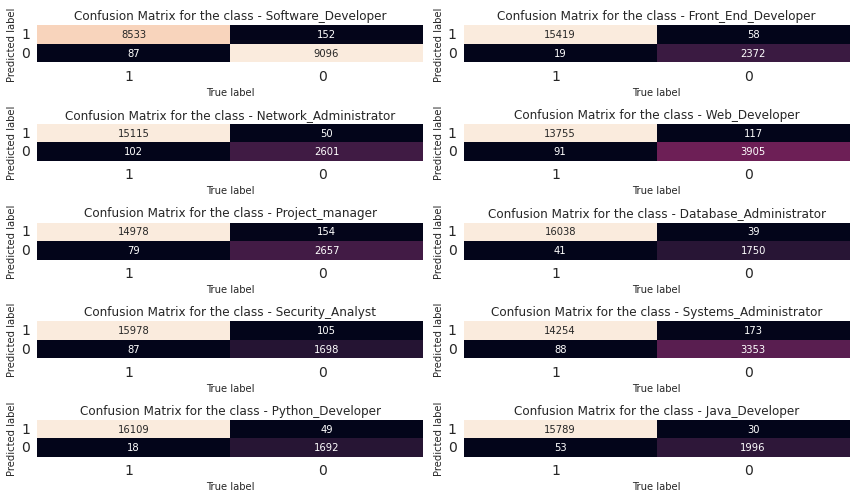

In [73]:
#print_confusion_matrix(mcm(targets, val_preds),class_label=labels, class_names=labels)
sns.set_style("whitegrid")
fig, ax = plt.subplots(5, 2, figsize=(12, 7))
for axes, cfs_matrix, label in zip(ax.flatten(), cm, cm_labels):
  print_confusion_matrix(cfs_matrix, axes, label, ["1", "0"])
    
fig.tight_layout()
plt.show()